In [1]:
import pandas as pd
import numpy as np
import dotenv
import os
from scipy import sparse
import pickle
import gc

dotenv.load_dotenv('.env')

True

In [2]:
!mkdir data
!gsutil rsync gs://{os.environ['GCP_BUCKET']}/data data
!kaggle competitions download -f sample_submission.csv --path ./data

mkdir: cannot create directory ‘data’: File exists
Building synchronization state...
Starting synchronization...
Using competition: avito-demand-prediction
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
cat_cols = [
    'image_top_1', 
    'region_code', 
    'city_code', 
    'parent_category_name_code', 
    'category_name_code', 
    'user_type_code', 
    'param_1_code', 
    'param_2_code', 
    'param_3_code',
    'user_id_code',
    'item_seq_number_code',
    'activation_date_weekday_code',
    'activation_date_month_code',
    'activation_date_day_code',
    'title_length',
    'title_space_count',
    'description_length',
    'description_space_count',
]
cont_cols = ['price_std']


def load_data(t):
    df = pd.read_parquet('./data/%s_prep.snappy.parquet'%t, columns=cat_cols+cont_cols)

    prep = sparse.csr_matrix(df.values)
    
    title_tfidf = sparse.load_npz('./data/%s_title_tfidf.npz'%t)
    description_tfidf = sparse.load_npz('./data/%s_description_tfidf.npz'%t)
    tfidf_features = pickle.load(open('./data/tfidf_feature_names.pl', 'rb'))

    feature_names = df.columns.tolist() + ['title_%s'%f for f in tfidf_features] + ['description_%s'%f for f in tfidf_features]
    features = sparse.hstack([prep, title_tfidf, description_tfidf])

    return features, feature_names

In [4]:
X_train, X_cols = load_data('train')
y_train, y_cols = pd.read_parquet('./data/train_prep.snappy.parquet', columns=['deal_probability'])['deal_probability'], ['deal_probability']

In [7]:
y_cols

'deal_probability'

In [0]:
!mkdir dataset


In [0]:
from sklearn.model_selection import train_test_split

X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_cv, y_cv, test_size=0.2, random_state=456)
        
lgb_cv = lgb.Dataset(X_cv, y_cv, feature_name=X_names)
lgb_train = lgb.Dataset(X_train, y_train, feature_name=X_names)
lgb_val = lgb.Dataset(X_valid, y_valid, feature_name=X_names)
lgb_test = lgb.Dataset(X_test, y_test, feature_name=X_names)


# del X, y; gc.collect()

In [0]:
#TODO: how to setup gpu lightgbm in colab
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'rmse',
    'metric': {'rmse'},
#     'min_data_in_leaf': 1000,
#     'num_leaves': 250,
#     'feature_fraction': 0.8,
#     'bagging_freq': 10,
#     'bagging_fraction': 0.5,
#     'max_depth': 8,
#     'min_data_in_leaf': 1000,
#     'device': 'gpu',
    'verbose': 1
}

lgb_params = {
    'verbose_eval': 10,
    'feature_name': X_names,
    'categorical_feature': cat_cols
}

In [0]:
K_FOLD=5

results = lgb.cv(
    params,
    lgb_cv,
    stratified=False,
    nfold=K_FOLD,
    seed=42,
    num_boost_round=10000,
    early_stopping_rounds=100,
    **lgb_params
)

[10]	cv_agg's rmse: 0.235733 + 0.000723525
[20]	cv_agg's rmse: 0.230504 + 0.000781008
[30]	cv_agg's rmse: 0.22874 + 0.000773208
[40]	cv_agg's rmse: 0.227816 + 0.000739939
[50]	cv_agg's rmse: 0.227195 + 0.00077381
[60]	cv_agg's rmse: 0.226809 + 0.000758186
[70]	cv_agg's rmse: 0.226529 + 0.000784576
[80]	cv_agg's rmse: 0.226362 + 0.000776039
[90]	cv_agg's rmse: 0.226214 + 0.000764074
[100]	cv_agg's rmse: 0.226092 + 0.000764306
[110]	cv_agg's rmse: 0.22599 + 0.000768353
[120]	cv_agg's rmse: 0.225909 + 0.000765205
[130]	cv_agg's rmse: 0.225854 + 0.000761646
[140]	cv_agg's rmse: 0.225807 + 0.000748026
[150]	cv_agg's rmse: 0.225758 + 0.00073132
[160]	cv_agg's rmse: 0.225729 + 0.000731311
[170]	cv_agg's rmse: 0.225694 + 0.000728642
[180]	cv_agg's rmse: 0.225658 + 0.000722698
[190]	cv_agg's rmse: 0.225637 + 0.000722976
[200]	cv_agg's rmse: 0.225606 + 0.000729716
[210]	cv_agg's rmse: 0.225586 + 0.000727996
[220]	cv_agg's rmse: 0.225551 + 0.000727243
[230]	cv_agg's rmse: 0.225546 + 0.000728381
[

In [0]:
cv = results['rmse-mean'][-1]
rounds = len(results['rmse-mean'])
rounds, cv, K_FOLD, 1/K_FOLD

(340, 0.22545001564822892, 5, 0.2)

In [0]:
model = lgb.train(
    params,
    lgb_train,
    valid_names=['train', 'valid', 'test'],
    valid_sets=[lgb_train, lgb_val, lgb_test],
    num_boost_round=rounds,
    **lgb_params
)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['activation_date_day_code', 'activation_date_month_code', 'activation_date_weekday_code', 'category_name_code', 'city_code', 'description_length', 'description_space_count', 'image_top_1', 'item_seq_number_code', 'param_1_code', 'param_2_code', 'param_3_code', 'parent_category_name_code', 'region_code', 'title_length', 'title_space_count', 'user_id_code', 'user_type_code']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[10]	train's rmse: 0.235205	valid's rmse: 0.234697	test's rmse: 0.236013
[20]	train's rmse: 0.229407	valid's rmse: 0.229188	test's rmse: 0.230591
[30]	train's rmse: 0.2268	valid's rmse: 0.226852	test's rmse: 0.22854
[40]	train's rmse: 0.224972	valid's rmse: 0.225242	test's rmse: 0.227248
[50]	train's rmse: 0.223676	valid's rmse: 0.224152	test's rmse: 0.226468
[60]	train's rmse: 0.222647	valid's rmse: 0.223321	test's rmse: 0.225965
[70]	train's rmse: 0.221807	valid's rmse: 0.222672	test's rmse: 0.225604
[80]	train's rmse: 0.221049	valid's rmse: 0.222098	test's rmse: 0.225328
[90]	train's rmse: 0.220382	valid's rmse: 0.221584	test's rmse: 0.225109
[100]	train's rmse: 0.219785	valid's rmse: 0.221137	test's rmse: 0.224895
[110]	train's rmse: 0.219219	valid's rmse: 0.220721	test's rmse: 0.224742
[120]	train's rmse: 0.218674	valid's rmse: 0.220312	test's rmse: 0.224586
[130]	train's rmse: 0.218229	valid's rmse: 0.219997	test's rmse: 0.224476
[140]	train's rmse: 0.217737	valid's rmse: 0.21966

Text(0.5,1,'Light GBM Feature Importance')

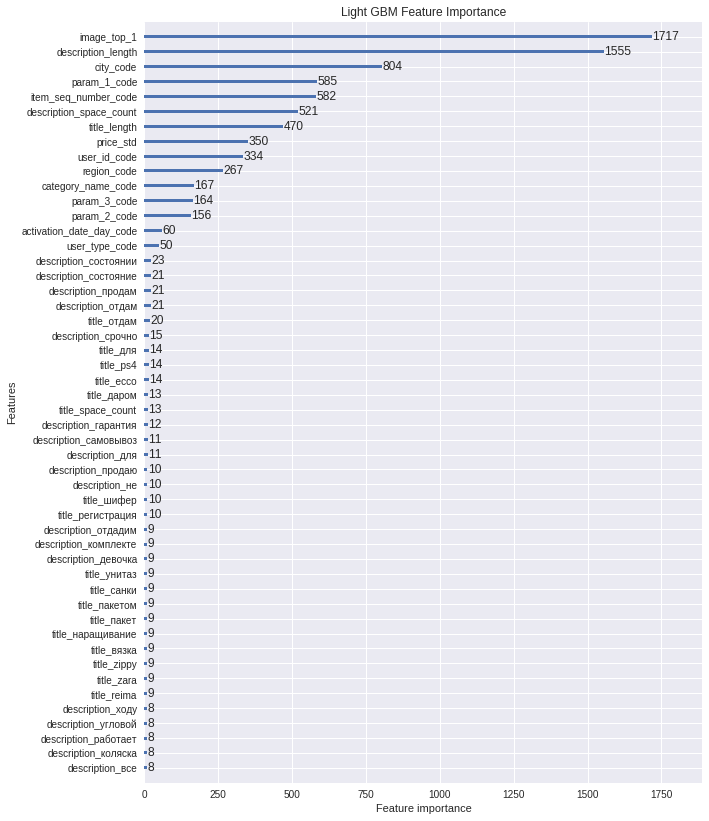

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 14))
lgb.plot_importance(model, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")

In [0]:
model.best_score

defaultdict(dict,
            {1: {},
             'test': {'rmse': 0.22333099336877052},
             'train': {'rmse': 0.21120373151218413},
             'valid': {'rmse': 0.21523884202017657}})

In [0]:
!mkdir ./model
model.save_model('./model/lightgbm.dat')
!gsutil rsync model gs://{os.environ['GCP_BUCKET']}/model

Building synchronization state...
Starting synchronization...
Copying file://model/lightgbm.dat [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/9.5 MiB.                                      


In [0]:
test = pd.read_parquet('./data/test_prep.snappy.parquet').set_index('item_id')
X_test, _ = load_data('test')
submission = pd.read_csv('./data/sample_submission.csv').set_index('item_id')
model = lgb.Booster(model_file='./model/lightgbm.dat')

{}

In [0]:
SUBMISSION_FILE='lightgbm.csv'
# SUBMISSION_MESSAGE='"LightGBM train %.4f valid %.4f test %.4f"'%(model.best_score['train']['rmse'], model.best_score['valid']['rmse'], model.best_score['test']['rmse'])
SUBMISSION_MESSAGE='"LightGBM train %.4f valid %.4f test %.4f"'%(0.2112, 0.2152, 0.2233)

# TODO: how to limit LightGBM regression mode to output [0., 1]
test['deal_probability'] = model.predict(X_test).clip(0., 1.)
submission['deal_probability'] = test['deal_probability'].reindex(submission.index)
submission.to_csv(SUBMISSION_FILE)
print(SUBMISSION_MESSAGE)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:450: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


"LightGBM train 0.2112 valid 0.2152 test 0.2233"


In [0]:
assert len(test.index) == len(submission.index)

In [0]:
!kaggle competitions submit -f '{SUBMISSION_FILE}' -m '{SUBMISSION_MESSAGE}'

Using competition: avito-demand-prediction
Successfully submitted to Avito Demand Prediction Challenge